In [23]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [24]:
env = BlackjackEnv()


In [28]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    # this is the where you give a probability ε/n to every possible action
    # and probability of 1-ε + ε/n for the best one.
    def policy_fn(observation):
        probabilities = np.ones(nA) * epsilon / nA
        # for the best one we have a high probability
        best_action = np.argmax(Q[observation])
        probabilities[best_action] = 1 - epsilon + epsilon/nA
        return probabilities
        
    return policy_fn

In [72]:
l = [1,2,3,4,5]
fo = 2
for i, ll in enumerate(l[2:][::-1]):
    print(i, ll)
    
a = 3
b = 1 if a < 2 else 0

b

0 5
1 4
2 3


0

In [53]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    # 1. compute the new policy you want to follow using 
    # make_epsilon_greedy_policy from your present Q function
    # 2. compute the new Q function based on a set of episodes 
    # sampled from the environment based on the new policy.
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    """
    TODO: initialize policy, Q, Returns
    """

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ###############################################################################################
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        # range is arbitrary, it should just not be shorter then any possible episode.
        for t in range(100):
            # Todo: only use policy not update
            # Does this have to be in the loop?
            policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
            action_prob = policy(state)
            value = np.random.uniform(0,1)
            # Since there is only two actions. Hit and stick        
            action = 0 if value < action_prob[0] else 1      # one-line if-statement 
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            
        ########TODO: We should calculate action value, not average return#################################
        # p 99 in book
        # G = 0
        # loop through all states in the episode
        # G = gamma * G +  R (reward at current state) 
        # If (S_t, A_t) unseen:
            # Append G to Returns(S_t, A_t)
            # Q(S_t, A_t) = average(Returns(S_t, A_t))
            # π(S_t) = argmax_a(Q(S_t, a))
        
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        # states_in_episode = set([tuple(x[0]) for x in episode])
        
        # for state in states_in_episode: why like this
        seen_state_actions = list()
        for state in episode:   # state = (St, At, Rt)
            
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state[0])
            # why do we do this ^ ?
            
            # Sum up all rewards since the first occurance
            # G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # to get newest rewards first, see cell above
            G = sum([x[2]*(discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:][::-1])])
            # Calculate average return for this state over all sampled episodes
            # TODO: Calculate action value
            ### NEW
            if state[:-1] not in seen_state_actions:
                seen_state_actions.append(state[:-1])
                returns_sum[state[:-1]] += G
                returns_count[state[:-1]] += 1.0
                Q[state[0]][action[0]] = returns_sum[state[:-1]] / returns_count[state[:-1]]
                # π(S_t) = argmax_a(Q(S_t, a))
                # initiate pi somewhere/how
                pi[state[0]] = np.argmaxQ[state[0]]
                
            ### OLD
            returns_sum[state] += G
            returns_count[state] += 1.0
            Q[state][action] = returns_sum[state] / returns_count[state]
            """
            TODO: update policy here instead
            """
    
    # Implement this!
    
    return Q, policy

    

In [54]:
start = time.clock()

Q, policy = mc_control_epsilon_greedy(env, num_episodes=50000, epsilon=0.1)
#Q2, policy2 = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

end = time.clock()
print("\n",end - start,"s")

Episode 50000/50000.
 10.243141000000008 s


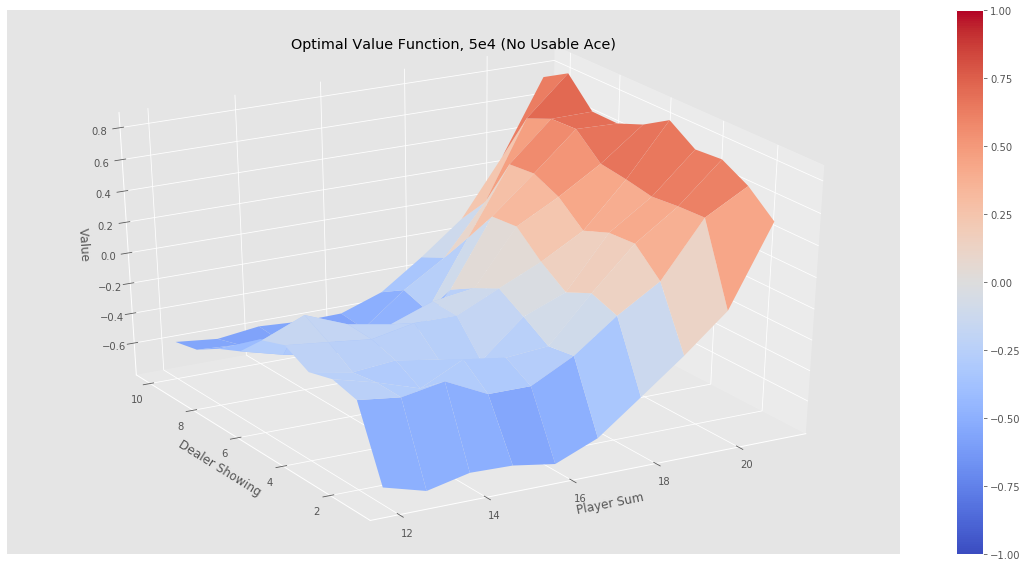

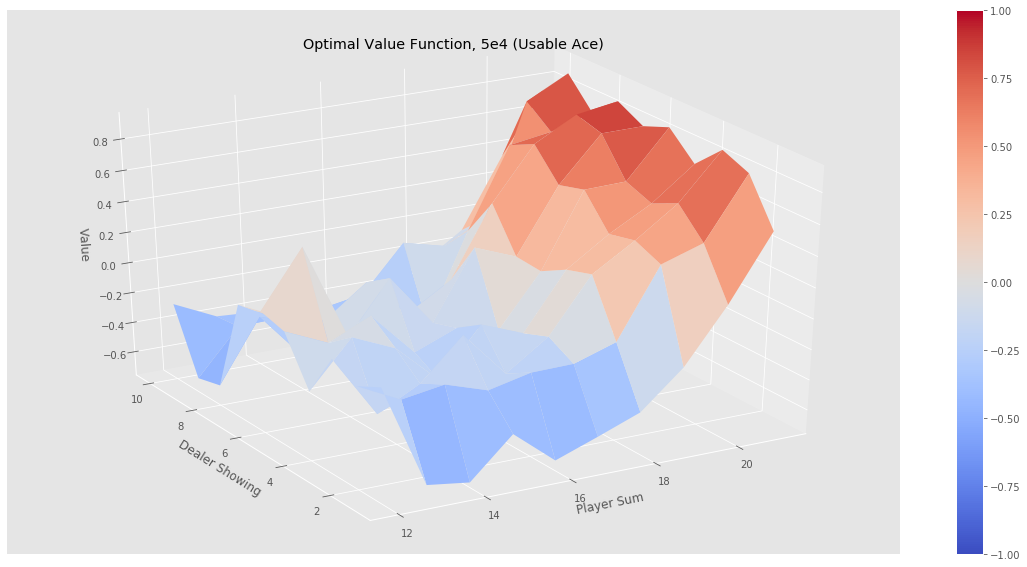

In [48]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function, 5e4")


In [41]:
Q


defaultdict(<function __main__.mc_control_epsilon_greedy.<locals>.<lambda>()>,
            {(20, 10, False): array([0.30692076, 0.30273834]),
             (19, 2, True): array([ 0.4137931, -1.       ]),
             (17, 10, True): array([-0.53112033, -0.6779661 ]),
             (20, 7, False): array([0.63428571, 0.63076923]),
             (18, 6, False): array([0.28338762, 0.26421405]),
             (13, 2, False): array([-0.27272727, -0.27014218]),
             (21, 5, False): array([0.74285714, 0.73267327]),
             (12, 8, False): array([-0.47058824, -0.47173913]),
             (21, 8, True): array([0.83796296, 0.8490566 ]),
             (14, 5, False): array([-0.19518072, -0.2       ]),
             (17, 10, False): array([-0.47543353, -0.47574222]),
             (15, 10, False): array([-0.5719721 , -0.57315522]),
             (21, 10, False): array([0.75365344, 0.74778761]),
             (12, 6, False): array([-0.20833333, -0.20745921]),
             (12, 9, False): array([-